In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import astropy.wcs as wcs

import sys

import os

# CAN ALSO WORK WITH PYPATH
sys.path.insert(0,'libraries/')
import ratio_density as rat
from image import Astro_Image
from image import ColDens_Image

In [2]:
#### INPUT ####

## for the fits files to open
file_name_1 = 'Ipeak_4sigmaMusca_C18O21_TP_kelvin_Smto10'
path_1 = '../data/ALMA/fitting_results/'
label_1 = 'C$^{18}$O(2-1)'
cal_unc_1 = 0.1 ## 10%

file_name_2 = 'Ipeak_4sigmaMusca_C18O10_TP_kelvin'
path_2 = '../data/ALMA/fitting_results/'
label_2 = 'C$^{18}$O(1-0)'
cal_unc_2 = 0.1 ## 10%

file_name_cont = 'musca_coldens_high250_clean_2d'
path_cont = '../data/Herschel/'
label_cont = 'N$_{H_{2}}$ (cm$^{-2}$)'

## contour information
levs_cont = [2.0e21 + i*1.0e21 for i in range(0,6)]
wids_cont = [0.7 for lev in levs_cont]

## information to map density with constraints from Herschel
file_name_colDens = 'musca_coldens_high250_clean_2d'
path_colDens = '../data/Herschel/'
label_colDens = 'N$_{H_{2}}$ (cm$^{-2}$)'

file_name_Tdust = 'musca_temp_r500_clean_2d'
path_Tdust = '../data/Herschel/'
label_Tdust = 'T$_{dust}$ (K)'

## plotting information
label_map = 'T$_{C^{18}O(2-1)}$/T$_{C^{18}O(1-0)}$'
x1_pl = 60.
x2_pl = 300.
y1_pl = 25.
y2_pl = 345.
max_colDens = 5.5e21

## information for the density calculation (fixed mol. col. density, linewidth and kinetic temperature)
mol = 'c18o'
line_1 = '2-1'
line_2 = '1-0'
fwhm = '0p25'
fit_order = 4 ## order of the polynomial that will be fitted
min_dens = 1e3
max_dens = 1e4
label_density = "n$_{H_{2}}$ (cm$^{-3}$)"
c18o_abundance = 1./(7.3*60*1e4)
#print(c18o_abundance)
grid_path = '../Radex/bin/results/smallGrid-FWHM=0p25'

## correction for the dust temperature in the Herschel map
Tdust_corr = -2.

In [3]:
## open the fits files
hdu = pyfits.open(path_1 + file_name_1 + '.fits')
hdu.info()
data_1 = hdu[0].data
header_1 = hdu[0].header
w_1 = wcs.WCS(header_1)

hdu = pyfits.open(path_2 + file_name_2 + '.fits')
hdu.info()
data_2 = hdu[0].data
header_2 = hdu[0].header
w_2 = wcs.WCS(header_2)

hdu_3 = pyfits.open(path_cont + file_name_cont + '.fits')
hdu_3.info()

hdu_N = pyfits.open(path_colDens + file_name_colDens + '.fits')
hdu_N.info()
data_N = hdu_N[0].data
header_N = hdu_N[0].header

hdu_T = pyfits.open(path_Tdust + file_name_Tdust + '.fits')
hdu_T.info()
data_T = hdu_T[0].data
header_T = hdu_T[0].header

Filename: ../data/ALMA/fitting_results/Ipeak_4sigmaMusca_C18O21_TP_kelvin_Smto10.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     101   (360, 385)   float64   
Filename: ../data/ALMA/fitting_results/Ipeak_4sigmaMusca_C18O10_TP_kelvin.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      79   (360, 385)   float64   
Filename: ../data/Herschel/musca_coldens_high250_clean_2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   (2800, 3800)   float32   
Filename: ../data/Herschel/musca_coldens_high250_clean_2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   (2800, 3800)   float32   
Filename: ../data/Herschel/musca_temp_r500_clean_2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   (2800, 3800)   float32   


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [4]:
## remove data not present in other map
data_1[np.isnan(data_2)] = np.nan
data_2[np.isnan(data_1)] = np.nan

In [5]:
## calculate the ratio map
map_ratio = rat.ratio_map(data_1, data_2, header_1, rel_uncs = [cal_unc_1, cal_unc_2])

In [6]:
## create Astro/ColDens images
im_colDens = ColDens_Image(data_N, header_N)
im_Tdust = Astro_Image(data_T, header_T)

## reproject Herschel maps to the grid of the spectral line data and save it as an Astro/ColDens_Image
im_colDens_rep = im_colDens.reproject_image(header_1)
im_Tdust_rep = im_Tdust.reproject_image(header_1)

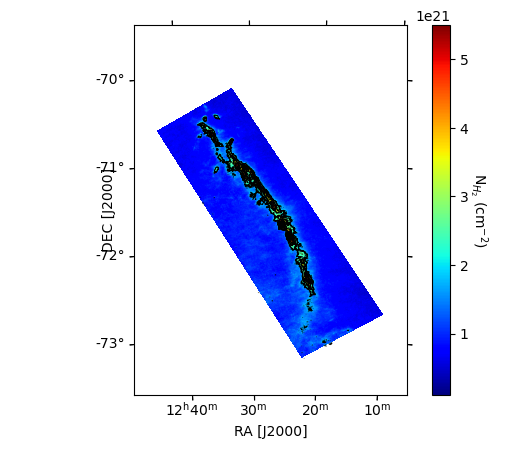

In [7]:
## plot the column density map
im_colDens.plot_image(label_colDens, max_val=max_colDens, contour_hdu = hdu_3, levs_cont = levs_cont, wids_cont = wids_cont)

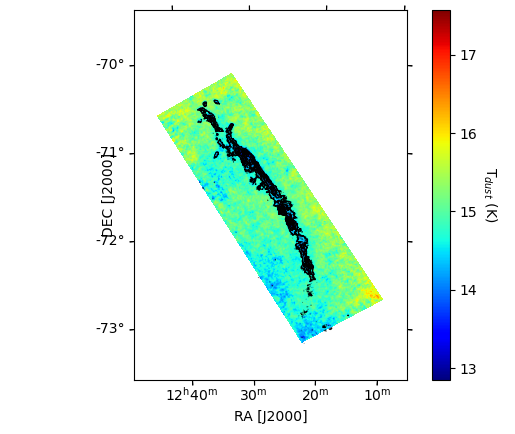

In [8]:
## plot the dust temperature map
im_Tdust.plot_image(label_Tdust, contour_hdu = hdu_3, levs_cont = levs_cont, wids_cont = wids_cont)

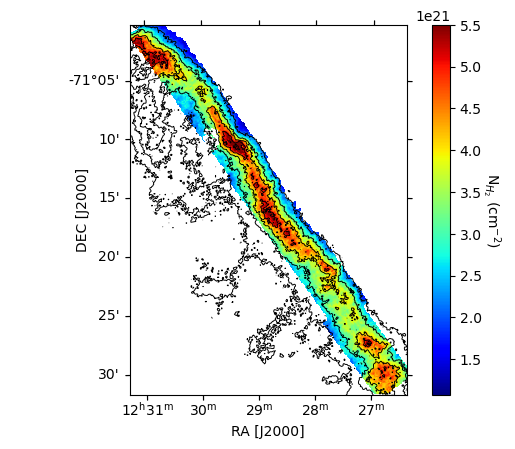

In [9]:
## filter the Herschel images based on the ALMA images mask
mask = np.zeros((len(data_1),len(data_1[0])), dtype=int)
mask[np.isnan(data_1)] = 1
im_colDens_rep.mask_values(mask)
im_Tdust_rep.mask_values(mask)

## verify
im_colDens_rep.plot_image(label_colDens, max_val=max_colDens, contour_hdu = hdu_3, plot_lims = [x1_pl,x2_pl,y1_pl,y2_pl], levs_cont = levs_cont, wids_cont = wids_cont)

0.25544756297728
37.9249236115456


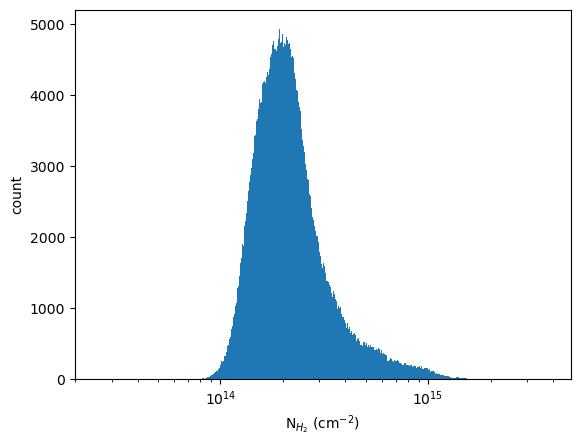

In [10]:
## inspect the column density range of the map for C18O
min_colDens, max_colDens = im_colDens.get_mol_colDens_range(c18o_abundance)
print(min_colDens/1e14)
print(max_colDens/1e14)

im_colDens.histogram_mol_colDens(c18o_abundance, label_colDens, log_xscale_bool = True)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


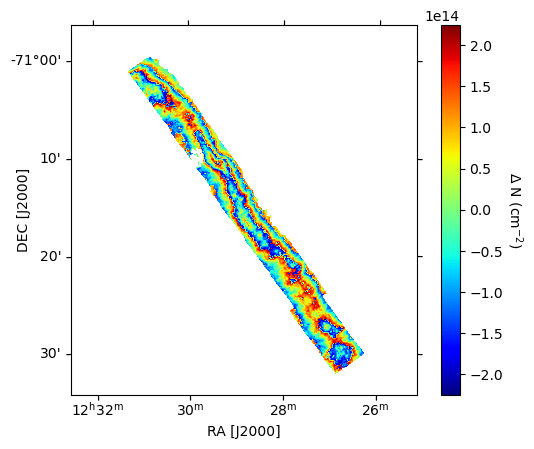

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


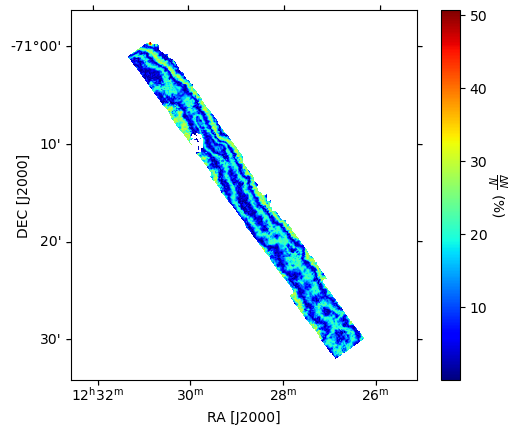

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


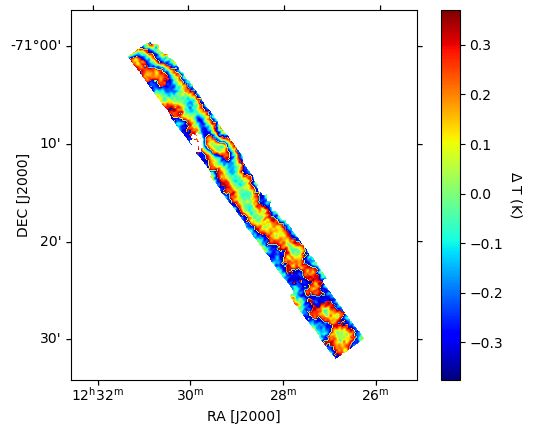

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


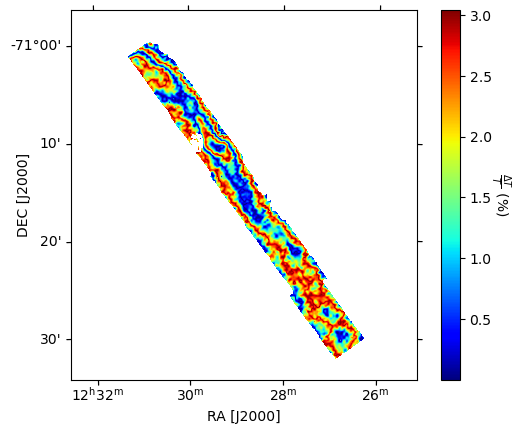

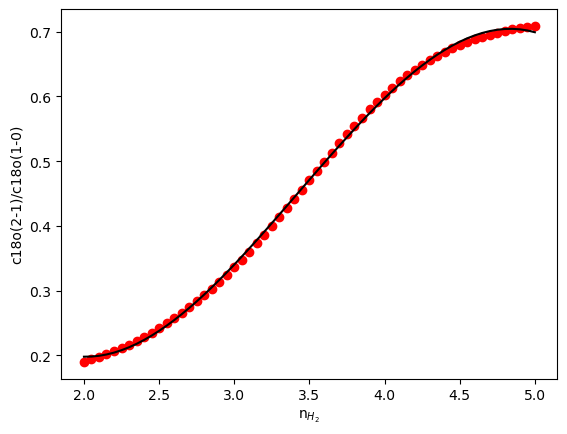

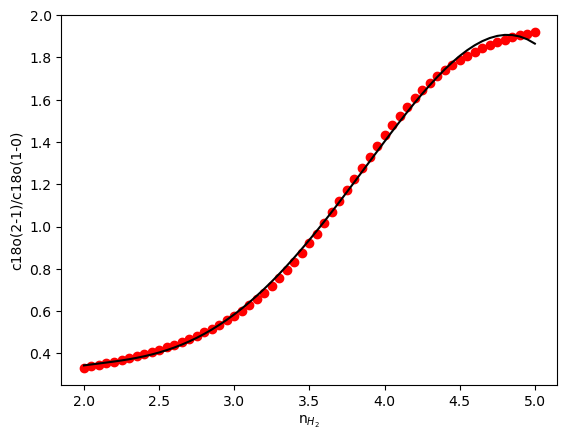

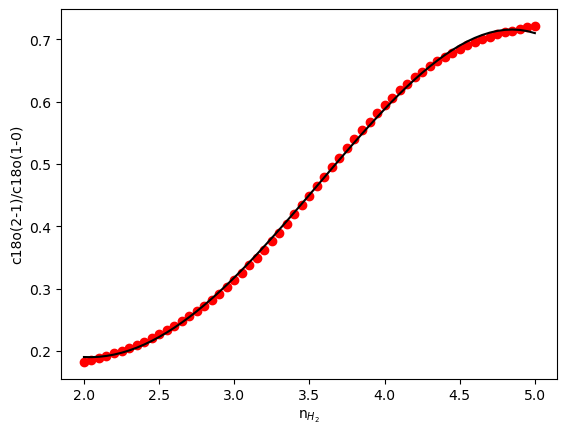

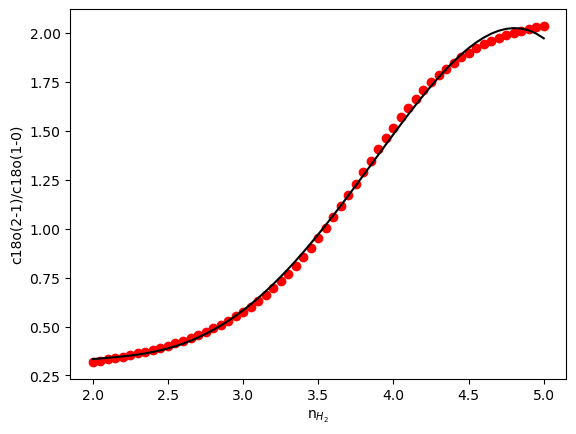

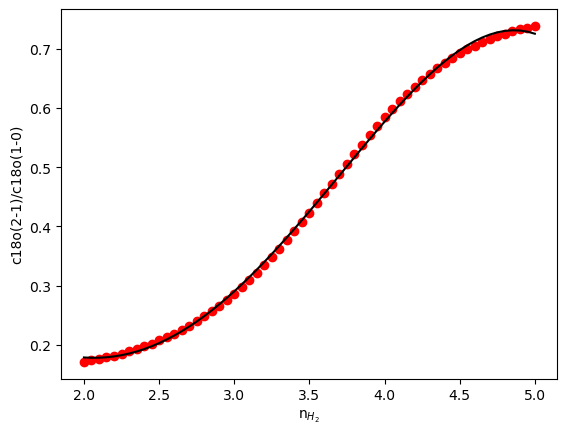

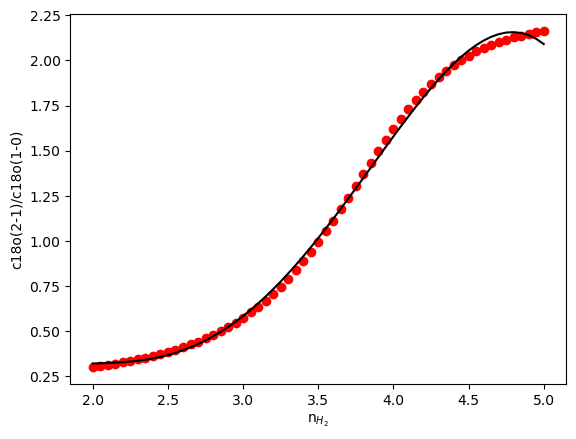

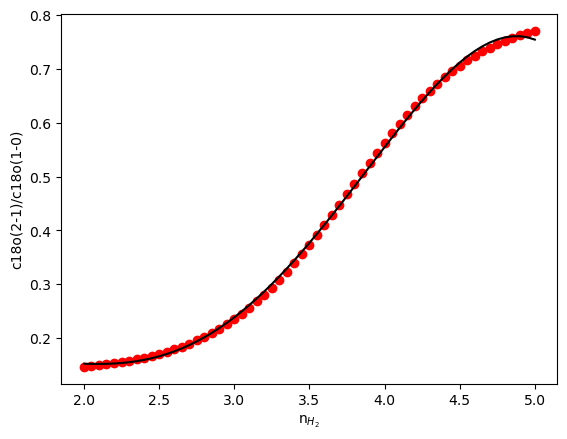

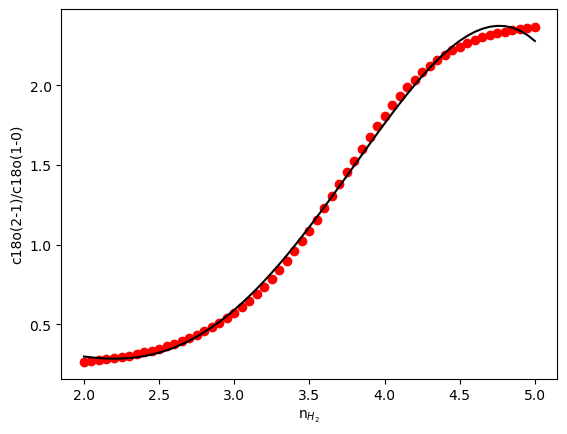

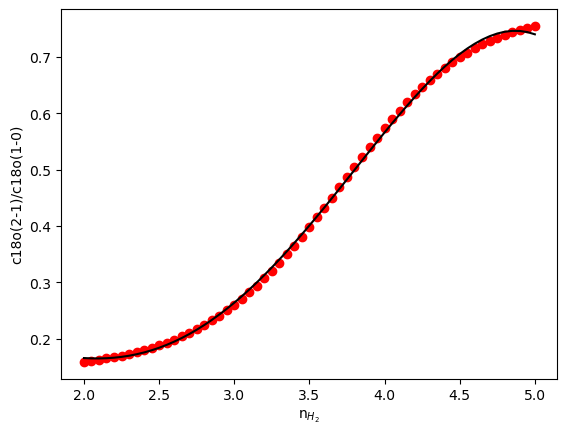

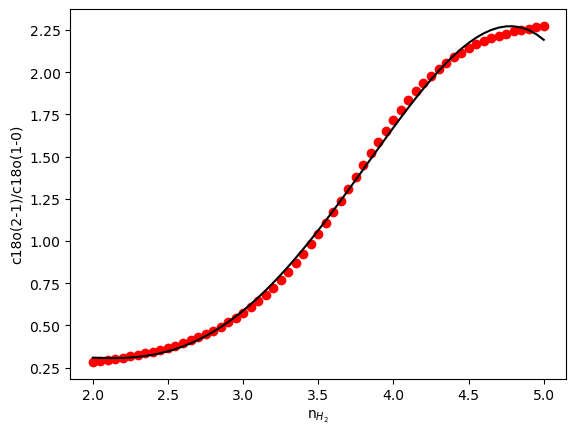

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


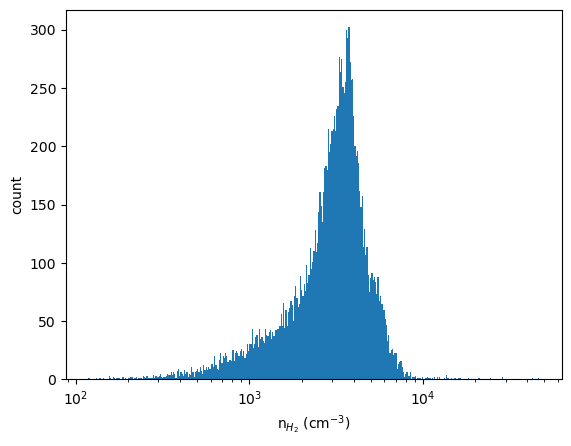

In [11]:
# SEND IMAGES ALONG INSTEAD OF THE COLUMN DENSITY
image_density, image_density_low, image_density_up = map_ratio.get_density_ratio_from_colDens_and_abundance(mol, line_1, line_2, fwhm, c18o_abundance, im_colDens_rep, im_Tdust_rep, grid_path, Tdust_corr = Tdust_corr, log_bool = False, poly_order = fit_order)

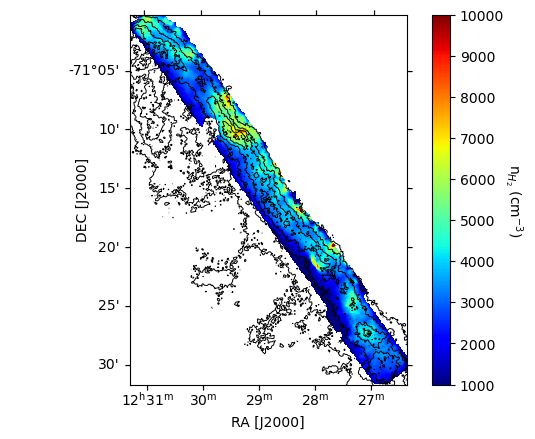

In [12]:
## plot the density map with the contours
image_density.plot_image(label_density, min_val = min_dens, max_val = max_dens, contour_hdu = hdu_3, plot_lims = [x1_pl,x2_pl,y1_pl,y2_pl], levs_cont = levs_cont, wids_cont = wids_cont)

## Analyze the uncertainties

In [13]:
## calculate the upper and lower uncertainty value (note that the errorbars are necessarily symmetric)
low_err = (image_density.astro_image - image_density_low.astro_image)
up_err = (image_density_up.astro_image - image_density.astro_image)

## combine the upper and lower uncertainty value into an estimate for a single uncertainty value and relative uncertainty
av_err = np.nanmean(np.array([low_err, up_err]), axis = 0)
perc_err = 100.*av_err/image_density.astro_image

## store the uncertainties as an image
im_low_err = Astro_Image(low_err, image_density_low.header)
im_up_err = Astro_Image(up_err, image_density_up.header)
im_av_err = Astro_Image(av_err, image_density_up.header)
im_perc_err = Astro_Image(perc_err, image_density_up.header)

/var/folders/pb/xs3f5mtd5bq7lmrql1dj8p040000gn/T/ipykernel_21408/524727884.py:6: RuntimeWarning: Mean of empty slice
  av_err = np.nanmean(np.array([low_err, up_err]), axis = 0)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


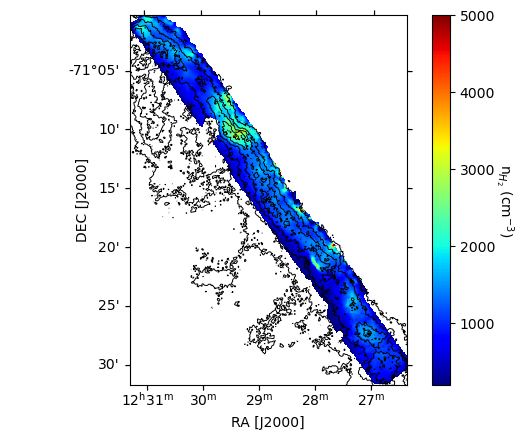

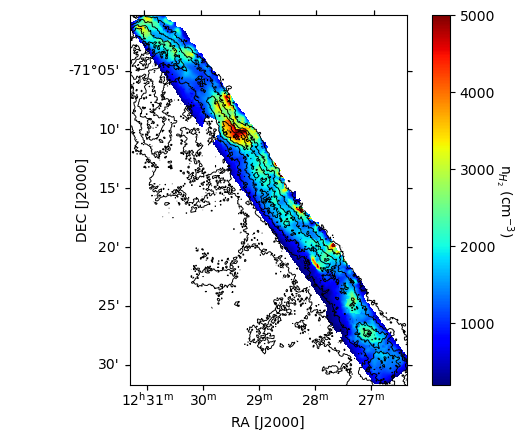

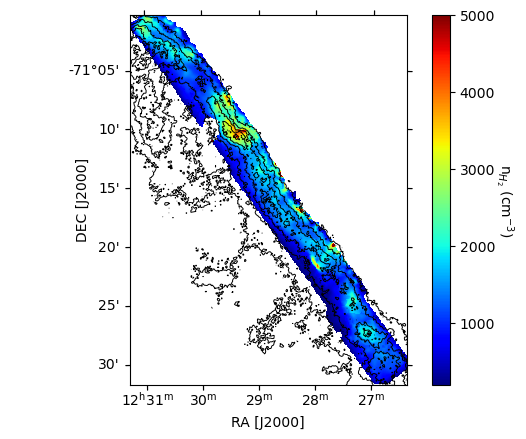

In [14]:
im_low_err.plot_image(label_density, min_val = 0.2*min_dens, max_val = 0.5*max_dens, contour_hdu = hdu_3, plot_lims = [x1_pl,x2_pl,y1_pl,y2_pl], levs_cont = levs_cont, wids_cont = wids_cont)
im_up_err.plot_image(label_density, min_val = 0.2*min_dens, max_val = 0.5*max_dens, contour_hdu = hdu_3, plot_lims = [x1_pl,x2_pl,y1_pl,y2_pl], levs_cont = levs_cont, wids_cont = wids_cont)
im_av_err.plot_image(label_density, min_val = 0.2*min_dens, max_val = 0.5*max_dens, contour_hdu = hdu_3, plot_lims = [x1_pl,x2_pl,y1_pl,y2_pl], levs_cont = levs_cont, wids_cont = wids_cont)

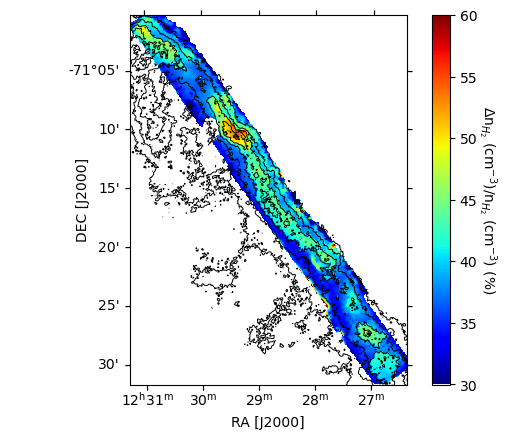

In [15]:
im_perc_err.plot_image(r'$\Delta$'+label_density+'/'+label_density+' (%)', min_val = 30., max_val = 60., contour_hdu = hdu_3, plot_lims = [x1_pl,x2_pl,y1_pl,y2_pl], levs_cont = levs_cont, wids_cont = wids_cont)